**LOAD LIBRARIES**



In [1]:
import numpy as np
import csv
import json
import re
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.metrics import precision_score as sk_precision
from sklearn.metrics import f1_score, confusion_matrix
from tqdm import tqdm
from multiprocessing import Pool
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

main_path = '/content/drive/My Drive/Colab Notebooks/nlp2020-hw1'


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**DATASET HANDLER**

Run every time. 


In [0]:
def vocabularize(paths, save_path=None):
    '''
    # This function creates a vocabulary containing both cased and lowercased words
    # The purpose of this is to train NER model with mixture of cased and lowercased sentences 
    # which was proved to work best on average for cased and lowercased datasets
    '''

    characters = ''
    words = []

    #* Word vocabulary    
    for path in paths:
        with open(path, 'r') as f:
            for sentence in f:
                sentence = sentence.strip()
                if sentence.startswith('#'):
                    lower_sentence = sentence.lower()
                    lower_sentence = lower_sentence.split()
                    sentence = sentence.split()
                    unique_words = list(set(sentence[1:]+lower_sentence[1:]))
                    words.extend(unique_words)
            f.close()

    words = sorted(list(set(words)))
    words.insert(0, '<UNK>')
    words.insert(0, '<PAD>')
    wordtoindex = {v: k for k, v in enumerate(words)}
    indextoword = {k: v for k, v in enumerate(words)}
    vocab = {'w2i' : wordtoindex,
             'i2w' : indextoword}

    #* Char vocabulary
    for path in paths:
            with open(path, 'r') as f:
                reader = f.read()
                reader += reader.lower()
                characters += reader
                f.close()
    characters = sorted(list(set(characters)))
    characters.remove('\n')
    characters.remove('\t')
    characters.insert(0, '<UNK>')
    characters.insert(0, '<PAD>')

    chartoindex = {v: k for k, v in enumerate(characters)}
    indextochar = {k: v for k, v in enumerate(characters)}
    char_vocab = {  'c2i' : chartoindex,
                    'i2c' : indextochar}

    print("Word vocabulary size: ", len(words))
    print("Char vocabulary size: ", len(characters))
    if save_path:
        np.save(save_path+'wordsList', words)
        with open(save_path+'word_vocab.json', 'w') as f:
            json.dump(vocab, f)
            f.close()
        np.save(save_path+'charList', characters)
        with open(save_path+'char_vocab.json', 'w') as f:
            json.dump(char_vocab, f)
            f.close()
    return char_vocab, vocab, characters, words


class DataSetHandler:
    '''
    A class for building a dataset out of provided data, given also vocabularies for words and characters.
    '''
    def __init__(self, 
                batch_size, 
                word_vocabulary, 
                char_vocabulary,
                ignore_singletons = False):
        self.batch_size = batch_size
        self.word_vocabulary = word_vocabulary['w2i']
        self.char_vocabulary = char_vocabulary['c2i']   

        # Flags that check what type of dataset is stored. str format or int format (vocabulary index)     
        self.enumerated = False
        self.str_dataset = False

        self.counter = 0

        # A flag for randomly turning words occuring once in the data set to the <UNK> tag.
        self.ignore_singletons = ignore_singletons

    def load_dataset(self, file_path, shuffle=False):
        '''
        This function loads str format dataset
        '''
        self.dataset = np.load(file_path, allow_pickle=True)
        self.data_len = len(self.dataset)
        self.str_dataset = True
        if shuffle: np.random.shuffle(self.dataset)
        print('Dataset in {} loaded. Number of samples: {}'.format(file_path, self.data_len))

    def load_enumerated_dataset(self, file_path, shuffle=False):
        '''
        This function loads int format dataset
        '''
        self.enum_dataset = np.load(file_path, allow_pickle=True)
        self.data_len = len(self.enum_dataset)
        self.enumerated = True
        if shuffle: np.random.shuffle(self.enum_dataset)
        print('Enumerated dataset in {} loaded. Number of samples: {}'.format(file_path, self.data_len))


    def create_dataset(self, file_path, mode = 'true', shuffle=False):
        '''
        Creates str format dataset.
        mode: Stands for capitalization mode. Either 'true' for true case, 'lower' for lower case and 'mixed' for both true and lower case together.
        '''

        self.mode = mode.lower()
        assert self.mode == 'true' or self.mode == 'lower' or self.mode == 'mixed', "Mode variable, denoting casing, should either be 'true', 'lower' or 'mixed'."

        with open(file_path, 'r') as tsv:
            sentences = tsv.read().split('#')[1:]
            tsv.close()

        self.dataset = []
        for data in sentences:
            data = data.strip().split('\n')
            assert len(data[0].split()) == len(data[1:])

            tokens, chars, labels = [], [], []
            lower_tokens, lower_chars = [], []
            for line in data[1:]:
                _, token, label = line.split('\t')

                #* Case mode handling
                if self.mode == 'lower':
                    token = token.lower()
                elif self.mode == 'mixed':
                    lower_token = token.lower()
                    lower_tokens.append(lower_token)
                    lower_chars.append(list(lower_token))

                tokens.append(token)
                chars.append(list(token))

                #* Label handling : ORG -> 1, PER -> 2, LOC -> 3, O -> 4
                if label == 'ORG':
                    label = 1
                elif label == 'PER':
                    label = 2
                elif label == 'LOC':
                    label = 3
                elif label == 'O':
                    label = 4
                else:
                    print("Problem with this label: ", label)
                labels.append(label)

            self.dataset.append((tokens, chars, labels))
            if self.mode == 'mixed':
                self.dataset.append((lower_tokens, lower_chars, labels))
        del sentences
        print('Dataset has been created.')

        self.data_len = len(self.dataset)
        self.str_dataset = True
        if shuffle: np.random.shuffle(self.dataset)
        if self.ignore_singletons: self.tokenfreq()

    def enumerate(self, data):
        '''
        Enumeration stands for turning the str formatted data into int format showing indices in the vocabulary.
        '''

        enum_data = []
        for sentence, chars, labels in tqdm(data):
            enum_sentence = []
            enum_chars = []
            for word, cword in zip(sentence, chars):
                # Word enumeration
                if word in self.wordkeys:
                    if self.ignore_singletons and word in self.least_frequent and np.random.rand(1)[0] < 0.5:
                        '''
                        This replaces tokens with appearance less than one, with the <UNK> tag, with probability 0.5 . 
                        '''
                        enum_sentence.append(self.word_vocabulary['<UNK>'])
                    else:
                        enum_sentence.append(self.word_vocabulary[word])
                else:
                    enum_sentence.append(self.word_vocabulary['<UNK>'])
                enum_char = []

                # Character enumeration
                for char in cword:
                    if char in self.charkeys:
                        enum_char.append(self.char_vocabulary[char])
                    else:
                        enum_char.append(self.char_vocabulary['<UNK>'])
                enum_chars.append(enum_char)
            enum_data.append((enum_sentence, enum_chars, labels))
        return enum_data


    def token2index(self):
        '''
        Parallelly run four processes that enumerate the dataset.
        '''

        print('Enumerating the dataset.')
        
        self.enum_dataset = []
        self.wordkeys = list(self.word_vocabulary.keys())
        self.charkeys = list(self.char_vocabulary.keys())
        lenght = len(self.dataset)

        # This could have been automatized for an arbitrary number of processes but for the time of making this is how I went with it.
        data1 = self.dataset[:lenght//4]
        data2 = self.dataset[lenght//4 : lenght//2]
        data3 = self.dataset[lenght//2 : 3*lenght//4]
        data4 = self.dataset[3*lenght//4 :]
        results = []
        with Pool(4) as p:
            results = p.map(self.enumerate, [data1, data2, data3, data4])
        self.enum_dataset = [sample for data in results for sample in data]
    
        assert len(self.dataset) == len(self.enum_dataset), "Mistakes were made. Lenghts of the datasets don't match."
        self.enumerated = True
        print("Dataset has been enumerated.")
        return self.enum_dataset

    def __iter__(self):
        return self

    def __next__(self):
        '''
        Data set must be enumerated for this to work. 
        Takes a batch of data points, padds them and turns them into torch Tensors.
        Returns a batch, with the size spesified in the class constructor.
        '''

        if self.counter < self.data_len and self.enumerated:
            last = min(self.counter+self.batch_size, self.data_len)
            batch = self.enum_dataset[self.counter:last]

            # Sort for pack_padded_sequence funtion in the BiLSTM module.
            batch = np.array(sorted(batch, key=lambda d: len(d[0]), reverse=True))
            data_w = batch[:, 0] # List of tokens
            data_c = batch[:, 1] # List of list of characters
            data_y = batch[:, 2] # List of labels
            sentence_lengths = [len(i) for i in data_w]

            data_w = [torch.LongTensor(sentence) for sentence in data_w] 
            data_c = [[torch.LongTensor(word) for word in sentence] for sentence in data_c]
            y = [torch.LongTensor(i) for i in data_y]

            padded_w = pad_sequence(data_w, batch_first=True, padding_value=self.word_vocabulary['<PAD>'])
            padded_y = pad_sequence(y, batch_first=True, padding_value=0)
            self.counter = last
            return padded_w, data_c, padded_y, sentence_lengths
        else:
            if not self.enumerated:
                raise ValueError('Dataset must be enumerated first. Use the token2index() funtion.')
            self.counter = 0
            raise StopIteration()

    def save(self, save_path):
        if self.str_dataset:
            np.save(save_path, self.dataset, allow_pickle=True)
            print('Dataset has been saved in {}'.format(save_path))
        if self.enumerated:
            np.save(save_path+'_enumerated', self.enum_dataset, allow_pickle=True)
            print('Enumerated dataset has been saved in {}'.format(save_path+'_enumerated'))
        if not self.str_dataset and not self.enumerated:
            raise ValueError('There are no datasets to save.')

    def tokenfreq(self):
        '''
        Use this function only with the training set!
        Compute the frequency of each token.
        This is utilized later to replace least frequent tokens with the <UNK> tag.
        '''

        assert self.str_dataset, 'Dataset should be in string format.'

        self.token_fq = {k: 0 for k in self.word_vocabulary.keys()}
        for sentence, _, _ in self.dataset:
            for token in sentence:
                try:
                    self.token_fq[token] += 1
                except:
                    print("Unexpected token: ", token)

        aslist = sorted(list(self.token_fq.items()), key = lambda x: x[1])
        self.least_frequent = []
        n_replaced = 0
        for t, f in aslist:
            if f < 2:
                self.least_frequent.append(t)
        self.ignore_singletons = True

        return self.token_fq, self.least_frequent

**BUILD VOCABULARY**

Build once.

In [0]:
trainFileName = main_path+'/data/train.tsv'

vocabularize([trainFileName], main_path+'/data/')

**BUILD DATA SETS**

Build once.

In [0]:
trainFileName = main_path + '/data/' + 'train.tsv'
devFileName = main_path + '/data/' + 'dev.tsv'
testFileName = main_path + '/data/' + 'test.tsv'

with open(main_path + '/data/word_vocab.json', 'r') as f:
    word_vocab = json.load(f)
    f.close()
with open(main_path + '/data/char_vocab.json', 'r') as f:
    char_vocab = json.load(f)
    f.close()

trainset = DataSetHandler(32, word_vocab, char_vocab, ignore_singletons=True)
trainset.create_dataset(trainFileName, mode='true', shuffle=True)
trainset.token2index(num_workers = 5)
trainset.save(main_path + '/data/trainset_truecase_unk')

devset = DataSetHandler(32, word_vocab, char_vocab)
devset.create_dataset(devFileName, mode='true', shuffle=False)
devset.token2index(num_workers = 5)
devset.save(main_path + '/data/devset_truecase')

testset = DataSetHandler(32, word_vocab, char_vocab)
testset.create_dataset(testFileName, mode='true', shuffle=False)
testset.token2index(num_workers = 5)
testset.save(main_path + '/data/testset_truecase')

Dataset has been created.
Enumerating the dataset.


100%|██████████| 25000/25000 [1:28:28<00:00,  4.71it/s]


Dataset has been enumerated.
Dataset has been saved in /content/drive/My Drive/Colab Notebooks/nlp2020-hw1/data/trainset_truecase_unk
Enumerated dataset has been saved in /content/drive/My Drive/Colab Notebooks/nlp2020-hw1/data/trainset_truecase_unk_enumerated


**CREATE MODEL**



In [0]:
class nerBiLSTM(torch.nn.Module):
    def __init__(self, vocab_dim, embedding_dim, hidden_dim, output_dim, lr=1e-3):
        super(nerBiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.embedding_layer = torch.nn.Embedding(vocab_dim, embedding_dim, padding_idx=0)
        self.bilstm = torch.nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        self.fc = torch.nn.Linear(2*hidden_dim, output_dim)

        self.loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, sentence, X_lengths):
        x = sentence 
        x = self.embedding_layer(x)

        x = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths, batch_first=True)

        x, self.hidden = self.bilstm(x)        

        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        self.logits = self.fc(x)

        self.output = F.softmax(self.logits, dim=2)
        return self.logits, self.output

    def update(self, sentence, label, X_lengths):
        output, _ = self(sentence, X_lengths)

        output = output.view(-1, self.output_dim)

        label = label.contiguous()
        label = label.view(-1)

        self.optimizer.zero_grad()
        loss = self.loss_function(output, label)

        loss.backward()
        self.optimizer.step()
        return loss

    def evaluate(self, sentence, label, X_lengths):
        with torch.no_grad():
            output, _ = self(sentence, X_lengths)

            output = output.view(-1, self.output_dim)

            label = label.contiguous()
            label = label.view(-1)

            loss = self.loss_function(output, label)
        return loss

    def prediction(self, sentence, X_lengths):
        with torch.no_grad():
            _, output = self(sentence, X_lengths)
            return output[:, :, 1:]

    def save(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load(self, filepath, device):
        self.load_state_dict(torch.load(filepath, map_location=device))


#BEWARE : EXPERIMENTAL MODEL
class nerBiLSTM_EXP(torch.nn.Module):
    def __init__(self, vocab_dim, embedding_dim, hidden_dim, output_dim, lr=1e-3, lcf_dim = 1):
        super(nerBiLSTM_EXP, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lcf_dim = lcf_dim
        self.output_dim = output_dim
        self.embedding_layer = torch.nn.Embedding(vocab_dim, embedding_dim, padding_idx=0)
        self.bilstm = torch.nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
  
        self.fc = torch.nn.Linear(2*hidden_dim + output_dim -1 , output_dim)
        self.loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, sentence, X_lengths):
        x = sentence 
        x = self.embedding_layer(x)

        x = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths, batch_first=True)

        x, self.hidden = self.bilstm(x)        

        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        x = x.transpose(0, 1)
        self.logits = []
        self.output = []

        prev_label = torch.zeros((x.size()[1], self.output_dim-1)).to(x.device)

        # 'Condition' each instance on the previous label
        for sentence in x:
            exp = torch.cat((sentence, prev_label), -1)
            exp = self.fc(exp)
            self.logits.append(exp)
            exp = F.softmax(exp[:,1:], dim=-1)
            self.output.append(exp)
            prev_label = exp
        self.logits = torch.stack(self.logits, 0).transpose(0,1)
        self.output = torch.stack(self.output, 0).transpose(0,1)

        return self.logits, self.output

    def update(self, sentence, label, X_lengths):
        output, _ = self(sentence, X_lengths)
        output = output.contiguous()
        output = output.view(-1, self.output_dim)

        label = label.contiguous()
        label = label.view(-1)

        self.optimizer.zero_grad()
        loss = self.loss_function(output, label)

        loss.backward()
        self.optimizer.step()
        return loss

    def evaluate(self, sentence, label, X_lengths):
        with torch.no_grad():
            output, _ = self(sentence, X_lengths)
            output = output.contiguous()

            output = output.view(-1, self.output_dim)

            label = label.contiguous()
            label = label.view(-1)

            loss = self.loss_function(output, label)
        return loss

    def prediction(self, sentence, X_lengths):
        with torch.no_grad():
            _, output = self(sentence, X_lengths)
            return output

    def save(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load(self, filepath, device):
        self.load_state_dict(torch.load(filepath, map_location=device))


class nerBiLSTM_char(torch.nn.Module):
    '''
    BiLSTM with char embeddings and word embeddings. Like described in the reference paper.
    '''

    def __init__(self, 
                vocab_dim, 
                embedding_dim, 
                hidden_dim, 
                output_dim,
                char_vocab_dim, 
                char_embedding_dim,  
                char_hidden_dim,
                lr=1e-3,
                d_p=0.5):
        super(nerBiLSTM_char, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.char_hidden_dim = char_hidden_dim

        self.char_embedding_layer = torch.nn.Embedding(char_vocab_dim, char_embedding_dim, padding_idx = 0)
        self.char_f_lstm = torch.nn.LSTM(char_embedding_dim, char_hidden_dim, batch_first=True, bidirectional=False)
        self.char_b_lstm = torch.nn.LSTM(char_embedding_dim, char_hidden_dim, batch_first=True, bidirectional=False)

        self.dropout = torch.nn.Dropout(d_p)
        self.embedding_layer = torch.nn.Embedding(vocab_dim, embedding_dim, padding_idx=0)
        self.bilstm = torch.nn.LSTM(embedding_dim + char_hidden_dim*2, hidden_dim, bidirectional=True)

        self.fc = torch.nn.Linear(2*hidden_dim, output_dim)

        self.loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def character_embedding(self, sentences, max_len, device):
        embedded_sentence = []
        for sentence_char in sentences:
            lengths = np.array(list(map(len, sentence_char)))-1
            padded_tokens = pad_sequence(sentence_char, batch_first=True, padding_value=0)
            w = self.char_embedding_layer(padded_tokens.to(device))
            f = self.char_f_lstm(w)[0]
            f = f[np.arange(len(lengths)), lengths]
            b = self.char_b_lstm(w)[0][:, -1, :]
            w = torch.cat([f,b], dim = -1)
            n_words = len(w)
            pad = torch.zeros([max_len-n_words, w.size()[1]]).to(device)
            w = torch.cat([w, pad], dim=0)
            embedded_sentence.append(w)
        embedded_sentence = torch.stack(embedded_sentence, dim=0)

        return embedded_sentence

    def forward(self, sentences, characters, X_lengths):
        x = sentences
        x = self.embedding_layer(x)
        device = x.device
        chars = self.character_embedding(characters, int(torch.max(X_lengths).item()), device)
        
        x = torch.cat([x, chars], -1)
        x = self.dropout(x)
        x = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths, batch_first=True)

        x, self.hidden = self.bilstm(x)        

        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        self.logits = self.fc(x)
        self.output = F.softmax(self.logits, dim=2)
        return self.logits, self.output

    def update(self, sentence, characters, label, X_lengths):
        output, _ = self(sentence, characters, X_lengths)

        output = output.view(-1, self.output_dim)

        label = label.contiguous()
        label = label.view(-1)

        self.optimizer.zero_grad()
        loss = self.loss_function(output, label)

        loss.backward()
        self.optimizer.step()
        return loss

    def evaluate(self, sentence, characters, label, X_lengths):
        with torch.no_grad():
            output, _ = self(sentence, characters, X_lengths)

            output = output.view(-1, self.output_dim)

            label = label.contiguous()
            label = label.view(-1)

            loss = self.loss_function(output, label)
        return loss

    def prediction(self, sentence, characters, X_lengths):
        with torch.no_grad():
            _, output = self(sentence, characters, X_lengths)
            return output[:, :, 1:]

    def save(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load(self, filepath, device):
        self.load_state_dict(torch.load(filepath, map_location=device))


class nerBiLSTM_ULT(torch.nn.Module):
    def __init__(self, 
                vocab_dim, 
                embedding_dim, 
                hidden_dim, 
                output_dim,
                char_vocab_dim, 
                char_embedding_dim,  
                char_hidden_dim,
                lr=1e-3,
                d_p=0.5):
        super(nerBiLSTM_ULT, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.char_hidden_dim = char_hidden_dim

        self.char_embedding_layer = torch.nn.Embedding(char_vocab_dim, char_embedding_dim, padding_idx = 0)
        self.char_f_lstm = torch.nn.LSTM(char_embedding_dim, char_hidden_dim, batch_first=True, bidirectional=False)
        self.char_b_lstm = torch.nn.LSTM(char_embedding_dim, char_hidden_dim, batch_first=True, bidirectional=False)

        self.dropout = torch.nn.Dropout(d_p)
        self.embedding_layer = torch.nn.Embedding(vocab_dim, embedding_dim, padding_idx=0)
        self.bilstm = torch.nn.LSTM(embedding_dim + char_hidden_dim*2, hidden_dim, bidirectional=True)
  
        self.fc = torch.nn.Linear(2*hidden_dim + output_dim -1 , output_dim)
        self.loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def character_embedding(self, sentences, max_len, device):
        embedded_sentence = []
        for sentence_char in sentences:
            lengths = np.array(list(map(len, sentence_char)))-1
            padded_tokens = pad_sequence(sentence_char, batch_first=True, padding_value=0)
            w = self.char_embedding_layer(padded_tokens.to(device))
            f = self.char_f_lstm(w)[0]
            f = f[np.arange(len(lengths)), lengths]
            b = self.char_b_lstm(w)[0][:, -1, :]
            w = torch.cat([f,b], dim = -1)
            n_words = len(w)
            pad = torch.zeros([max_len-n_words, w.size()[1]]).to(device)
            w = torch.cat([w, pad], dim=0)
            embedded_sentence.append(w)
        embedded_sentence = torch.stack(embedded_sentence, dim=0)

        return embedded_sentence

    def forward(self, sentences, characters, X_lengths):
        x = sentences
        x = self.embedding_layer(x)
        device = x.device
        chars = self.character_embedding(characters, int(torch.max(X_lengths).item()), device)
        
        x = torch.cat([x, chars], -1)
        x = self.dropout(x)
        x = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths, batch_first=True)

        x, self.hidden = self.bilstm(x)        

        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        x = x.transpose(0, 1)
        self.logits = []
        self.output = []

        prev_label = torch.zeros((x.size()[1], self.output_dim-1)).to(x.device)

        # 'Condition' each instance on the previous label
        for sentence in x:
            exp = torch.cat((sentence, prev_label), -1)
            exp = self.fc(exp)
            self.logits.append(exp)
            exp = F.softmax(exp[:,1:], dim=-1)
            self.output.append(exp)
            prev_label = exp
        self.logits = torch.stack(self.logits, 0).transpose(0,1)
        self.output = torch.stack(self.output, 0).transpose(0,1)

        return self.logits, self.output

    def update(self, sentence, characters, label, X_lengths):
        output, _ = self(sentence, characters, X_lengths)
        output = output.contiguous()
        output = output.view(-1, self.output_dim)

        label = label.contiguous()
        label = label.view(-1)

        self.optimizer.zero_grad()
        loss = self.loss_function(output, label)

        loss.backward()
        self.optimizer.step()
        return loss

    def evaluate(self, sentence, characters, label, X_lengths):
        with torch.no_grad():
            output, _ = self(sentence, characters, X_lengths)
            output = output.contiguous()

            output = output.view(-1, self.output_dim)

            label = label.contiguous()
            label = label.view(-1)

            loss = self.loss_function(output, label)
        return loss

    def prediction(self, sentence, characters, X_lengths):
        with torch.no_grad():
            _, output = self(sentence, characters, X_lengths)
            return output

    def save(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load(self, filepath, device):
        self.load_state_dict(torch.load(filepath, map_location=device))

**HYPERPARAMETERS**

In [22]:
train_batch_size = 32
dev_batch_size = 128
test_batch_size = 128
EPOCHS = 25
EXPERIMENT = '10a'

save_path = main_path + '/experiments/experiment' + EXPERIMENT
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


**LOAD DATASETS and VOCABULARIES**

In [14]:
train_path = main_path + '/data/trainset_truecase_unk_enumerated.npy'
dev_path = main_path + '/data/devset_enumerated.npy'
test_path = main_path + '/data/testset_enumerated.npy'
with open(main_path + '/data/word_vocab.json', 'r') as f:
    word_vocab = json.load(f)
    f.close()
with open(main_path + '/data/char_vocab.json', 'r') as f:
    char_vocab = json.load(f)
    f.close()

trainset = DataSetHandler(train_batch_size, word_vocab, char_vocab)
trainset.load_enumerated_dataset(train_path, shuffle=True)

devset = DataSetHandler(dev_batch_size, word_vocab, char_vocab)
devset.load_enumerated_dataset(dev_path, shuffle=False)

testset = DataSetHandler(test_batch_size, word_vocab, char_vocab)
testset.load_enumerated_dataset(test_path, shuffle=False)

Enumerated dataset in /content/drive/My Drive/Colab Notebooks/nlp2020-hw1/data/trainset_truecase_unk_enumerated.npy loaded. Number of samples: 100000
Enumerated dataset in /content/drive/My Drive/Colab Notebooks/nlp2020-hw1/data/devset_enumerated.npy loaded. Number of samples: 14434
Enumerated dataset in /content/drive/My Drive/Colab Notebooks/nlp2020-hw1/data/testset_enumerated.npy loaded. Number of samples: 15474


**BUILD** **MODEL**

Build only the one you want to train or test.

In [0]:
vocab_dim = len(word_vocab['w2i'])
model = nerBiLSTM(vocab_dim, 100, 50, 5).to(device)
# model.load(save_path+'/model', device)

In [0]:
vocab_dim = len(word_vocab['w2i'])
model = nerBiLSTM_EXP(vocab_dim, 100, 50, 5).to(device)
# model.load(save_path+'/model', device)

In [0]:
vocab_dim = len(word_vocab['w2i'])
char_dim = len(char_vocab['c2i'])
model = nerBiLSTM_char(vocab_dim, 100, 50, 5, char_dim, 50, 25, d_p=0.0).to(device)
# model.load(save_path+'/model15', device)

In [0]:
vocab_dim = len(word_vocab['w2i'])
char_dim = len(char_vocab['c2i'])
model = nerBiLSTM_ULT(vocab_dim, 100, 50, 5, char_dim, 50, 25, d_p=0.0).to(device)
# model.load(save_path+'/model25', device)

**TRAINING**


In [0]:
training_losses = []
training_epoch_losses = []
dev_losses = []
test_accuracy = []
for epoch in range(1, EPOCHS+1):

    epoch_loss = 0
    episode = 1
    print('Training..')
    print('+=========================================+\n')
    for words, chars, label, lengths in trainset:
        # loss = model.update(words.to(device), label.to(device), torch.Tensor(lengths).to(device)) # For BiLSTM or BiLSTM_EXP
        loss = model.update(words.to(device), chars, label.to(device), torch.Tensor(lengths).to(device)) # For BiLSTM_char

        epoch_loss += loss.item()
        if not episode % 400:
            print('Epoch: {:2d}\tEpisode: {:3d}\tAvg Loss: {:4.6f}'.format(epoch, episode, epoch_loss/episode))
            training_losses.append(epoch_loss/episode)
        episode += 1
    print('Epoch: {:2d}\tTraining Loss: {:4.6f}'.format(epoch, epoch_loss/episode))
    training_epoch_losses.append(epoch_loss/episode)

    print('Validation.. ')
    print('+=========================================+\n')
    episode = 1
    epoch_loss = 0
    for words, chars, label, lengths in devset:
        # loss = model.evaluate(words.to(device), label.to(device), torch.Tensor(lengths).to(device)) # For BiLSTM or BiLSTM_EXP
        loss = model.evaluate(words.to(device), chars, label.to(device), torch.Tensor(lengths).to(device)) # For BiLSTM_char

        epoch_loss += loss.item()
        episode += 1
    print('Epoch: {:2d}\tValidation Loss: {:4.6f}'.format(epoch, epoch_loss/episode))
    dev_losses.append(epoch_loss/episode)

    model.save(save_path + '/model{}'.format(epoch))
    np.save(save_path + '/training_losses', training_losses)
    np.save(save_path + '/training_epoch_losses', training_epoch_losses)
    np.save(save_path + '/dev_losses', dev_losses)

**TESTING**

In [0]:
# Model selection
dev_losses = np.load(save_path+'/dev_losses.npy', allow_pickle=True)
training_epoch_losses = np.load(save_path+'/training_epoch_losses.npy', allow_pickle=True)
training_losses = np.load(save_path+'/training_losses.npy', allow_pickle=True)
for t, (i, j) in enumerate(zip(training_epoch_losses, dev_losses)):
  print(t+1, i, j)

In [27]:
test_accuracy = []
n_model = '26'
# for n_model in range(26,31):
predictions, labels = [], []
model.load(save_path+'/model{}'.format(n_model), device)

for w, c, y, l in testset:
    # prediction = model.prediction(w.cuda(), torch.Tensor(l).cuda()) # For BiLSTM or BiLSTM_EXP
    prediction = model.prediction(w.cuda(), c, torch.Tensor(l).cuda()) # For BiLSTM_char
    pred = torch.argmax(prediction, dim=2)
    pred += torch.ones_like(pred)
    x = torch.nn.utils.rnn.pack_padded_sequence(pred, l, batch_first=True)
    y = torch.nn.utils.rnn.pack_padded_sequence(y, l, batch_first=True)
    predictions.extend(x.data.tolist())
    labels.extend(y.data.tolist())

precision_micro = sk_precision(labels, predictions, average='micro')
precision_macro = sk_precision(labels, predictions, average='macro')
f1 = f1_score(labels, predictions, average='macro')
con_matrix = confusion_matrix(labels, predictions)
print("Model", n_model)
print("Precision Micro", precision_micro)
print("Precision Macro", precision_macro)
print("F1 Score       ", f1)
test_accuracy.append(precision_micro)
test_accuracy.append(precision_macro)
test_accuracy.append(f1)
np.save(save_path + '/test_accuracy', test_accuracy)

Model 26
Precision Micro 0.9863275192762194
Precision Macro 0.9339168715378928
F1 Score        0.9295148147428725


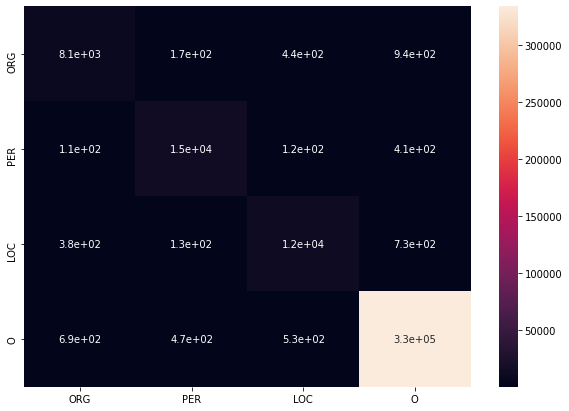

In [28]:

df_cm = pd.DataFrame(con_matrix, index = [i for i in ['ORG', 'PER', 'LOC', 'O']],
                  columns = [i for i in ['ORG', 'PER', 'LOC', 'O']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.savefig(save_path+'/confusion_matrix')
plt.show()